In [24]:
# System modules
import sys
import random
import time
import datetime 

# Data Analysis and Modeling modules
from sklearn import ensemble, neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import scipy as sp

In [25]:
# Data Visualization modules
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

# Visualization Configuration
# for jupyter notebook
%matplotlib inline 

In [3]:
train_data_raw = pd.read_csv("./data/train.csv.zip")
test_data = pd.read_csv("./data/test.csv.zip")
train_data = train_data_raw.copy(deep=True)

In [4]:
data_cleaner = [train_data, test_data]

In [5]:
# get a list of us federal holidays as a datetime object
from pandas.tseries.holiday import USFederalHolidayCalendar
days_off = USFederalHolidayCalendar().holidays(start='2003-01-01', end='2016-01-01').to_pydatetime()

In [6]:
for data in data_cleaner:
    # convert 'Dates' to datetime object
    data['Dates'] = pd.to_datetime(data['Dates'])
    data['month'] = data['Dates'].dt.month
    data['dayofmonth'] = data['Dates'].dt.day
    data['dayofyear'] = data['Dates'].dt.dayofyear
    data['year'] = data['Dates'].dt.year
    data['weekofyear'] = data['Dates'].dt.weekofyear
    data['hour'] = data['Dates'].dt.hour
    data['minute'] = data['Dates'].dt.minute
    # workhour
    data['Workhour'] = data['hour'].map(lambda x: 1 if x in range(9, 17) else 0)

    # holidays
    data['isHoliday'] = data['Dates'].isin(days_off).astype(int)

    # seasons
    # summer: check if month is between june and august (6-8)
    data['isSummer'] = data['month'].map(lambda x : 1 if x == 6 or x == 7 or x == 8 else 0)
    # winter: check if month is between dec and feb (12-2)
    data['isWinter'] = data['month'].map(lambda x : 1 if x == 12 or x == 1 or x == 2 else 0)
    # autumn: check if month is between sept and nov (9-11)
    data['isAutumn'] = data['month'].map(lambda x : 1 if x == 9 or x == 10 or x == 11 else 0)
    # spring: check if month is between march and may (3-5)
    data['isSpring'] = data['month'].map(lambda x : 1 if x == 3 or x == 4 or x == 5 else 0)

In [7]:
seasons = ['isSummer', 'isAutumn', 'isWinter', 'isSpring']
data[seasons].describe()

,isSummer,isAutumn,isWinter,isSpring
count,884262.000000,884262.000000,884262.000000,884262.000000
mean,0.247400,0.235924,0.257429,0.259247
std,0.431501,0.424575,0.437218,0.438221
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [8]:
print(train_data['PdDistrict'].unique())
train_data = pd.concat([train_data, pd.get_dummies(train_data['PdDistrict'])], axis=1)
test_data = pd.concat([test_data, pd.get_dummies(test_data['PdDistrict'])], axis=1)


# day of week, ie: monnday, wednesday, ...
train_data = pd.concat([train_data, pd.get_dummies(train_data['DayOfWeek'])], axis=1) 
test_data = pd.concat([test_data, pd.get_dummies(test_data['DayOfWeek'])], axis=1) 

data_cleaner = [train_data, test_data]

['NORTHERN' 'PARK' 'INGLESIDE' 'BAYVIEW' 'RICHMOND' 'CENTRAL' 'TARAVAL'
 'TENDERLOIN' 'MISSION' 'SOUTHERN']


In [9]:
train_data[train_data['PdDistrict'].unique()].head()

,NORTHERN,PARK,INGLESIDE,BAYVIEW,RICHMOND,CENTRAL,TARAVAL,TENDERLOIN,MISSION,SOUTHERN
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0


In [10]:
train_data[train_data['DayOfWeek'].unique()].head()

,Wednesday,Tuesday,Monday,Sunday,Saturday,Friday,Thursday
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


# Counting Crime

In [11]:
crimes_df = pd.get_dummies(train_data['Category'])
crimes = crimes_df.columns
train_data = pd.concat([train_data, crimes_df], axis=1)

In [12]:
train_data[crimes[:10]].head()

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [13]:
# monthly sum for each crime
month_sum_df = train_data.groupby(['month'])[crimes].transform('sum')
month_sum_df.columns = 'month_'+month_sum_df.columns+'_sum'

print('done month calcs')

# weekofyear sum for each crime
weekofyear_sum_df = train_data.groupby(['weekofyear'])[crimes].transform('sum')
weekofyear_sum_df.columns = 'weekofyear_'+weekofyear_sum_df.columns+'_sum'

print('done weekofyear calcs')

# dayofyear sum for each crime
dayofyear_sum_df = train_data.groupby(['dayofyear'])[crimes].transform('sum')
dayofyear_sum_df.columns = 'dayofyear_'+dayofyear_sum_df.columns+'_sum'

print('done dayofyear calcs')

done month calcs
done weekofyear calcs
done dayofyear calcs


In [43]:
# each PdDistrict sum for each crime
pd_districs = train_data['PdDistrict'].unique().tolist()
for district in pd_districs[0:2]:
    pd_df = train_data.groupby(pd_districs[0])[crimes].transform('sum')
    pd_df.columns = f'{district}'+pd_df
# dayofyear_sum_df = train_data.groupby(['dayofyear'])[crimes].transform('sum')
# dayofyear_sum_df.columns = 'dayofyear_'+dayofyear_sum_df.columns+'_sum'
pd_df['ARSON'].unique()

array([ 149., 1364.])

In [14]:
len(weekofyear_sum_df['weekofyear_ARSON_sum'].unique())

19

In [15]:
train_data = pd.concat([train_data, 
                        month_sum_df,
                        weekofyear_sum_df,
                        dayofyear_sum_df
                       ], 
                       axis=1)
print('done joining sum/median/mean dfs')

done joining sum/median/mean dfs


In [16]:
p = ['dayofyear'] + weekofyear_sum_df.columns
train_data[dayofyear_sum_df.columns.tolist()[:10]].head()

,dayofyear_ARSON_sum,dayofyear_ASSAULT_sum,dayofyear_BAD CHECKS_sum,dayofyear_BRIBERY_sum,dayofyear_BURGLARY_sum,dayofyear_DISORDERLY CONDUCT_sum,dayofyear_DRIVING UNDER THE INFLUENCE_sum,dayofyear_DRUG/NARCOTIC_sum,dayofyear_DRUNKENNESS_sum,dayofyear_EMBEZZLEMENT_sum
0,4,229.0,2,0,122,8,7,169.0,7,4
1,4,229.0,2,0,122,8,7,169.0,7,4
2,4,229.0,2,0,122,8,7,169.0,7,4
3,4,229.0,2,0,122,8,7,169.0,7,4
4,4,229.0,2,0,122,8,7,169.0,7,4


In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Columns: 195 entries, Dates to dayofyear_WEAPON LAWS_sum
dtypes: datetime64[ns](1), float64(52), int32(1), int64(12), object(6), uint8(123)
memory usage: 582.0+ MB


# GRAPH DATA

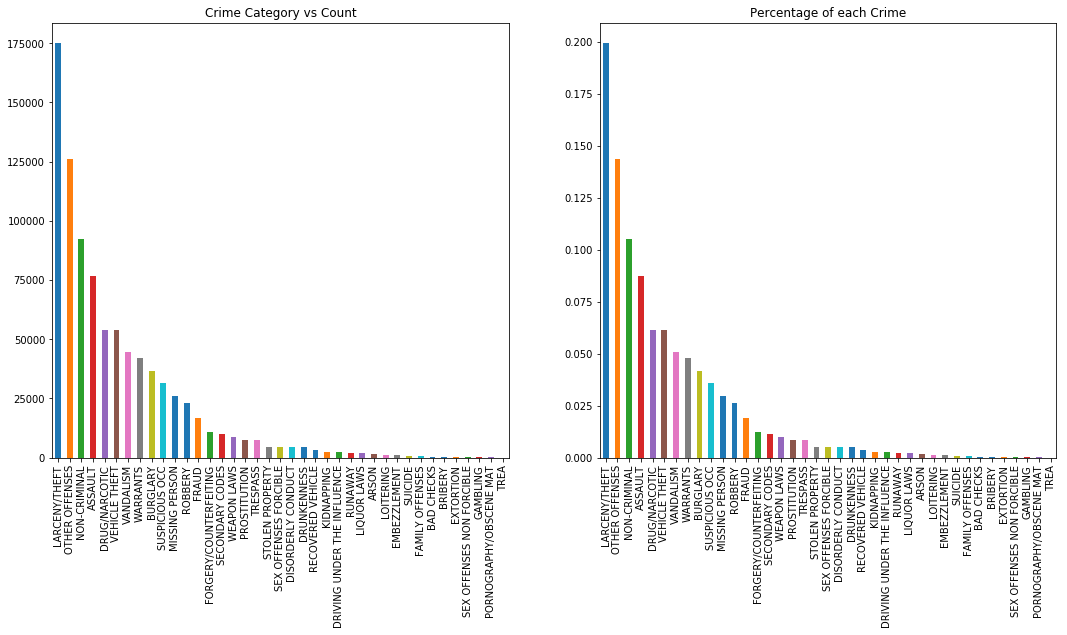

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
number_of_crimes = train_data['Category'].value_counts()
number_of_crimes.plot.bar(
    title="Crime Category vs Count", 
    ax=axes[0], 
)
percent_of_crime = number_of_crimes / sum(number_of_crimes)
percent_of_crime.plot.bar(
    title='Percentage of each Crime',
    ax=axes[1])

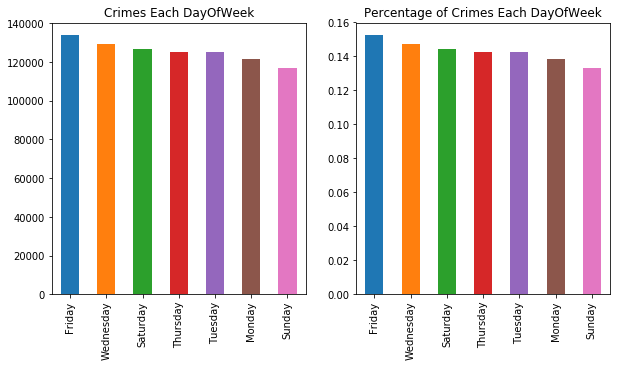

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
train_data['DayOfWeek'].value_counts().plot.bar(
    ax=axes[0],
    title="Crimes Each DayOfWeek"
)
percentace_dayofweek = train_data['DayOfWeek'].value_counts() / sum(train_data['DayOfWeek'].value_counts())
percentace_dayofweek.plot.bar(
    ax=axes[1], 
    title='Percentage of Crimes Each DayOfWeek')

- Most crime occurs during wednesday and Friday 
- Sunday is the least (maybe because of church)

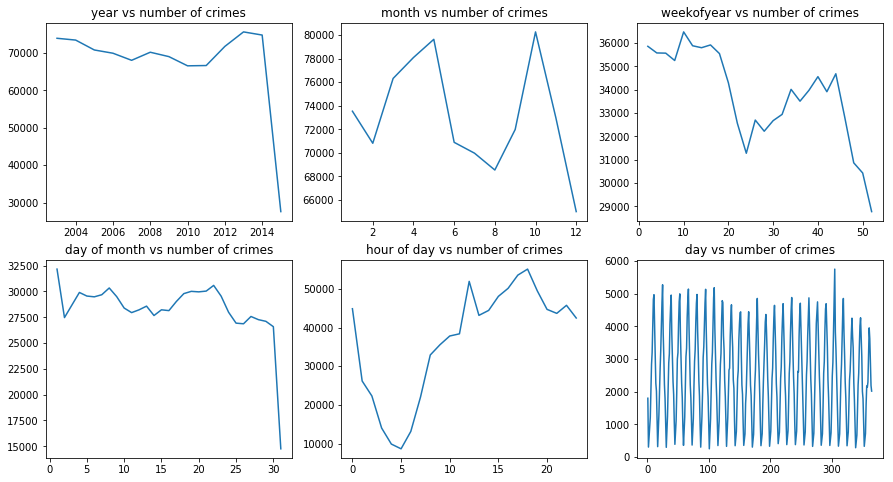

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(15,8))
train_data['year'].value_counts().sort_index().plot.line(
    title="year vs number of crimes",
    ax=axes[0,0]
)

train_data['month'].value_counts().sort_index().plot.line(
    title='month vs number of crimes',
    ax=axes[0,1]
)

train_data['weekofyear'].value_counts().sort_index().plot.line(
    title='weekofyear vs number of crimes', 
    ax=axes[0,2]
)

train_data['dayofmonth'].value_counts().sort_index().plot.line(
    title='day of month vs number of crimes', 
    ax=axes[1,0]
)
train_data['hour'].value_counts().sort_index().plot.line(
    title='hour of day vs number of crimes', 
    ax=axes[1,1]
)
train_data['dayofyear'].value_counts().sort_index().plot.line(
    title='day vs number of crimes', 
    ax=axes[1,2]
)

month_ARSON_sum
month_ASSAULT_sum
month_BAD CHECKS_sum
month_BRIBERY_sum
month_BURGLARY_sum
month_DISORDERLY CONDUCT_sum
month_DRIVING UNDER THE INFLUENCE_sum
month_DRUG/NARCOTIC_sum
month_DRUNKENNESS_sum
month_EMBEZZLEMENT_sum
month_EXTORTION_sum
month_FAMILY OFFENSES_sum
month_FORGERY/COUNTERFEITING_sum
month_FRAUD_sum


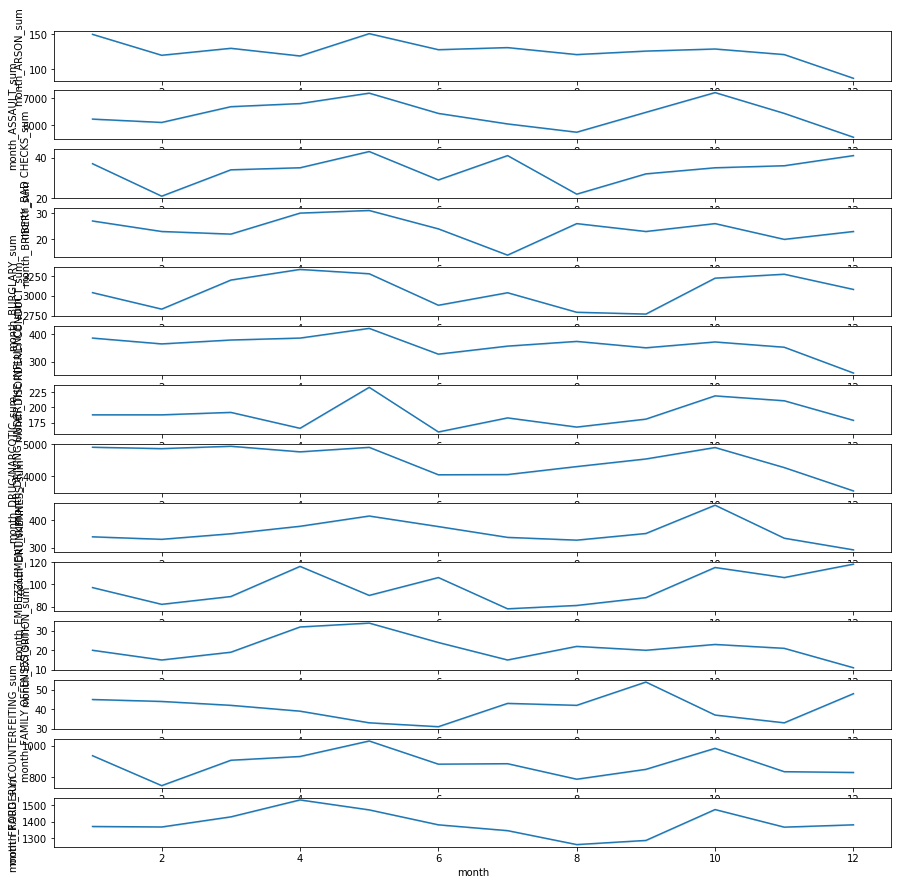

In [90]:
fig, axes = plt.subplots(14,1, figsize=(15, 20))
indx = 0
for crime in month_sum_df.columns[:14]:
    print(crime)
    sns.lineplot(x='month', y=crime, data=train_data, ax=axes[indx])
    indx+=1

In [98]:
train_data.columns.tolist()[:10]

['Dates',
 'Category',
 'Descript',
 'DayOfWeek',
 'PdDistrict',
 'Resolution',
 'Address',
 'X',
 'Y',
 'month']

In [21]:
targets = train_data[train_data['Category'].unique()]
features = train_data.drop(['Dates', 'Category', 'Resolution', 'Address', 'PdDistrict', 'DayOfWeek', 'Descript'], axis=1)

In [22]:
train_X, test_X, train_Y, test_Y = train_test_split(features, targets)

In [23]:
clf = ensemble.RandomForestClassifier()
clf.fit(train_X, train_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
print("Trainning Score: ", clf.score(train_X, train_Y))
print("Testing Score: ", clf.score(test_X, test_Y))

Trainning Score:  0.9998982591688229
Testing Score:  0.9965696792445095


In [41]:
train_log_loss_score = log_loss(y_true=train_Y, y_pred=clf.predict(train_X))
test_log_loss_score = log_loss(y_true=test_Y, y_pred=clf.predict(test_X))
print(f"Log_loss: {train_log_loss_score}")
print(f"Log_loss: {test_log_loss_score}")

Log_loss: 0.0003727338069844955
Log_loss: 0.012567191553776533


# Send Data for Data Visualization and Modeling

In [55]:
# processed data to csv file done here
train_data.to_csv('./data/processed_train_data.csv.gz', compression='gzip')
print('done writing train_data')
# test_data.to_csv('./data/processed_test_data.csv.gz',  compression='gzip')

KeyboardInterrupt: 